# FlexAttention Data Structure Exploration

**Date:** October 4, 2025

**Goal:** Understand the structure of the mock IceCube-like data used in FlexAttention benchmarking.

This notebook breaks down:
1. How the synthetic batch is created
2. The distribution of pulses per DOM
3. All tensor shapes and their meanings
4. How data flows through the processing pipeline

## Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add src to path
# sys.path.insert(0, str(Path.cwd().parent / "src"))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from iceaggr.utils import get_logger

logger = get_logger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0+cu128
Device available: cuda


## 1. Create Mock IceCube-Like Batch

The `create_icecube_like_batch` function creates synthetic data that mimics real IceCube pulse statistics:

**Pulse Distribution per DOM:**
- 60% of DOMs: 1-10 pulses (small)
- 25% of DOMs: 11-50 pulses (medium)
- 10% of DOMs: 51-200 pulses (large)
- 5% of DOMs: 201-1000 pulses (very large)

**Number of DOMs per Event:**
- Follows a Poisson distribution with mean ~63 DOMs

In [2]:
def create_icecube_like_batch(batch_size: int = 32, seed: int = 42):
    """
    Create synthetic batch matching IceCube pulse statistics.
    
    Returns a dictionary with:
    - pulse_features: (total_pulses, 4) - features for all pulses
    - pulse_to_dom_idx: (total_pulses,) - which DOM each pulse belongs to
    - dom_pulse_counts: (total_doms,) - number of pulses per DOM
    - dom_to_event_idx: (total_doms,) - which event each DOM belongs to
    - total_doms: int - total number of DOMs across all events
    - batch_size: int - number of events
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    all_pulses = []
    pulse_to_dom_idx = []
    dom_pulse_counts = []
    dom_to_event_idx = []

    dom_idx = 0

    for event_idx in range(batch_size):
        # Sample number of DOMs per event (Poisson with mean ~63)
        n_doms = max(1, np.random.poisson(63))

        for _ in range(n_doms):
            # Sample pulses per DOM from heavy-tailed distribution
            r = np.random.random()
            if r < 0.6:  # 60% small
                n_pulses = np.random.randint(1, 11)
            elif r < 0.85:  # 25% medium
                n_pulses = np.random.randint(11, 51)
            elif r < 0.95:  # 10% large
                n_pulses = np.random.randint(51, 201)
            else:  # 5% very large
                n_pulses = np.random.randint(201, 1001)

            # Create fake pulse features (time, charge, string, dom)
            pulses = torch.randn(n_pulses, 4)
            all_pulses.append(pulses)

            # Track which DOM each pulse belongs to
            pulse_to_dom_idx.extend([dom_idx] * n_pulses)
            dom_pulse_counts.append(n_pulses)
            dom_to_event_idx.append(event_idx)

            dom_idx += 1

    return {
        'pulse_features': torch.cat(all_pulses, dim=0),
        'pulse_to_dom_idx': torch.tensor(pulse_to_dom_idx, dtype=torch.long),
        'dom_pulse_counts': torch.tensor(dom_pulse_counts, dtype=torch.long),
        'dom_to_event_idx': torch.tensor(dom_to_event_idx, dtype=torch.long),
        'total_doms': dom_idx,
        'batch_size': batch_size
    }

# Create a small batch for exploration
batch = create_icecube_like_batch(batch_size=8, seed=42)

print("✓ Batch created successfully!")

✓ Batch created successfully!


## 2. Inspect Batch Structure

Let's examine what's in the batch dictionary and understand each component.

In [3]:
print("=" * 80)
print("BATCH CONTENTS")
print("=" * 80)

for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"\n{key}:")
        print(f"  Type: torch.Tensor")
        print(f"  Shape: {value.shape}")
        print(f"  Dtype: {value.dtype}")
        print(f"  Device: {value.device}")
    else:
        print(f"\n{key}: {value}")

BATCH CONTENTS

pulse_features:
  Type: torch.Tensor
  Shape: torch.Size([27408, 4])
  Dtype: torch.float32
  Device: cpu

pulse_to_dom_idx:
  Type: torch.Tensor
  Shape: torch.Size([27408])
  Dtype: torch.int64
  Device: cpu

dom_pulse_counts:
  Type: torch.Tensor
  Shape: torch.Size([492])
  Dtype: torch.int64
  Device: cpu

dom_to_event_idx:
  Type: torch.Tensor
  Shape: torch.Size([492])
  Dtype: torch.int64
  Device: cpu

total_doms: 492

batch_size: 8


## 3. Understanding Key Tensors

### 3.1 pulse_features

This tensor contains all pulse features concatenated together. Each row is a pulse with 4 features:
- Feature 0: time
- Feature 1: charge  
- Feature 2: string ID
- Feature 3: DOM ID

In [4]:
print("pulse_features shape:", batch['pulse_features'].shape)
print("\nFirst 10 pulses:")
print(batch['pulse_features'][:10])

print("\nStatistics per feature:")
for i in range(4):
    feature = batch['pulse_features'][:, i]
    print(f"  Feature {i}: mean={feature.mean():.3f}, std={feature.std():.3f}, "
          f"min={feature.min():.3f}, max={feature.max():.3f}")

pulse_features shape: torch.Size([27408, 4])

First 10 pulses:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  1.7174],
        [ 0.3189, -0.4245,  0.3057, -0.7746]])

Statistics per feature:
  Feature 0: mean=0.000, std=1.009, min=-4.285, max=4.132
  Feature 1: mean=0.004, std=1.001, min=-4.112, max=3.728
  Feature 2: mean=0.010, std=1.001, min=-3.862, max=4.391
  Feature 3: mean=0.004, std=1.003, min=-4.028, max=3.998


### 3.2 pulse_to_dom_idx

This tensor maps each pulse to its parent DOM. Each element is a DOM index.

In [7]:
print("pulse_to_dom_idx shape:", batch['pulse_to_dom_idx'].shape)
print("\nFirst 20 entries (which DOM each pulse belongs to):")
print(batch['pulse_to_dom_idx'][20:40])

print("\nUnique DOMs:", batch['pulse_to_dom_idx'].unique().numel())
print("Should match total_doms:", batch['total_doms'])

pulse_to_dom_idx shape: torch.Size([27408])

First 20 entries (which DOM each pulse belongs to):
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2])

Unique DOMs: 492
Should match total_doms: 492


### 3.3 dom_pulse_counts

This tensor tells us how many pulses each DOM has.

In [6]:
print("dom_pulse_counts shape:", batch['dom_pulse_counts'].shape)
print("\nFirst 20 DOMs and their pulse counts:")
print(batch['dom_pulse_counts'][:20])

print("\nPulse count statistics:")
print(f"  Min: {batch['dom_pulse_counts'].min().item()}")
print(f"  Max: {batch['dom_pulse_counts'].max().item()}")
print(f"  Mean: {batch['dom_pulse_counts'].float().mean().item():.2f}")
print(f"  Median: {batch['dom_pulse_counts'].float().median().item():.2f}")
print(f"  Total pulses: {batch['dom_pulse_counts'].sum().item()}")
print(f"  Should match pulse_features.shape[0]: {batch['pulse_features'].shape[0]}")

dom_pulse_counts shape: torch.Size([492])

First 20 DOMs and their pulse counts:
tensor([ 31,   3,   8,   8,  32,   8,  48,   5,  32,   9,  10,   3,   4,   3,
        185,   7,   9, 442,  10,   4])

Pulse count statistics:
  Min: 1
  Max: 991
  Mean: 55.71
  Median: 8.00
  Total pulses: 27408
  Should match pulse_features.shape[0]: 27408


### 3.4 dom_to_event_idx

This tensor maps each DOM to its parent event.

In [11]:
print("dom_to_event_idx shape:", batch['dom_to_event_idx'].shape)
print("\nFirst 30 DOMs and their event assignments:")
print(batch['dom_to_event_idx'][10:50])

print("\nDOMs per event:")
for event_idx in range(batch['batch_size']):
    n_doms = (batch['dom_to_event_idx'] == event_idx).sum().item()
    print(f"  Event {event_idx}: {n_doms} DOMs")

dom_to_event_idx shape: torch.Size([492])

First 30 DOMs and their event assignments:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

DOMs per event:
  Event 0: 60 DOMs
  Event 1: 74 DOMs
  Event 2: 49 DOMs
  Event 3: 54 DOMs
  Event 4: 69 DOMs
  Event 5: 63 DOMs
  Event 6: 54 DOMs
  Event 7: 69 DOMs


## 4. Visualize Pulse Distribution

Let's visualize the heavy-tailed distribution of pulses per DOM.

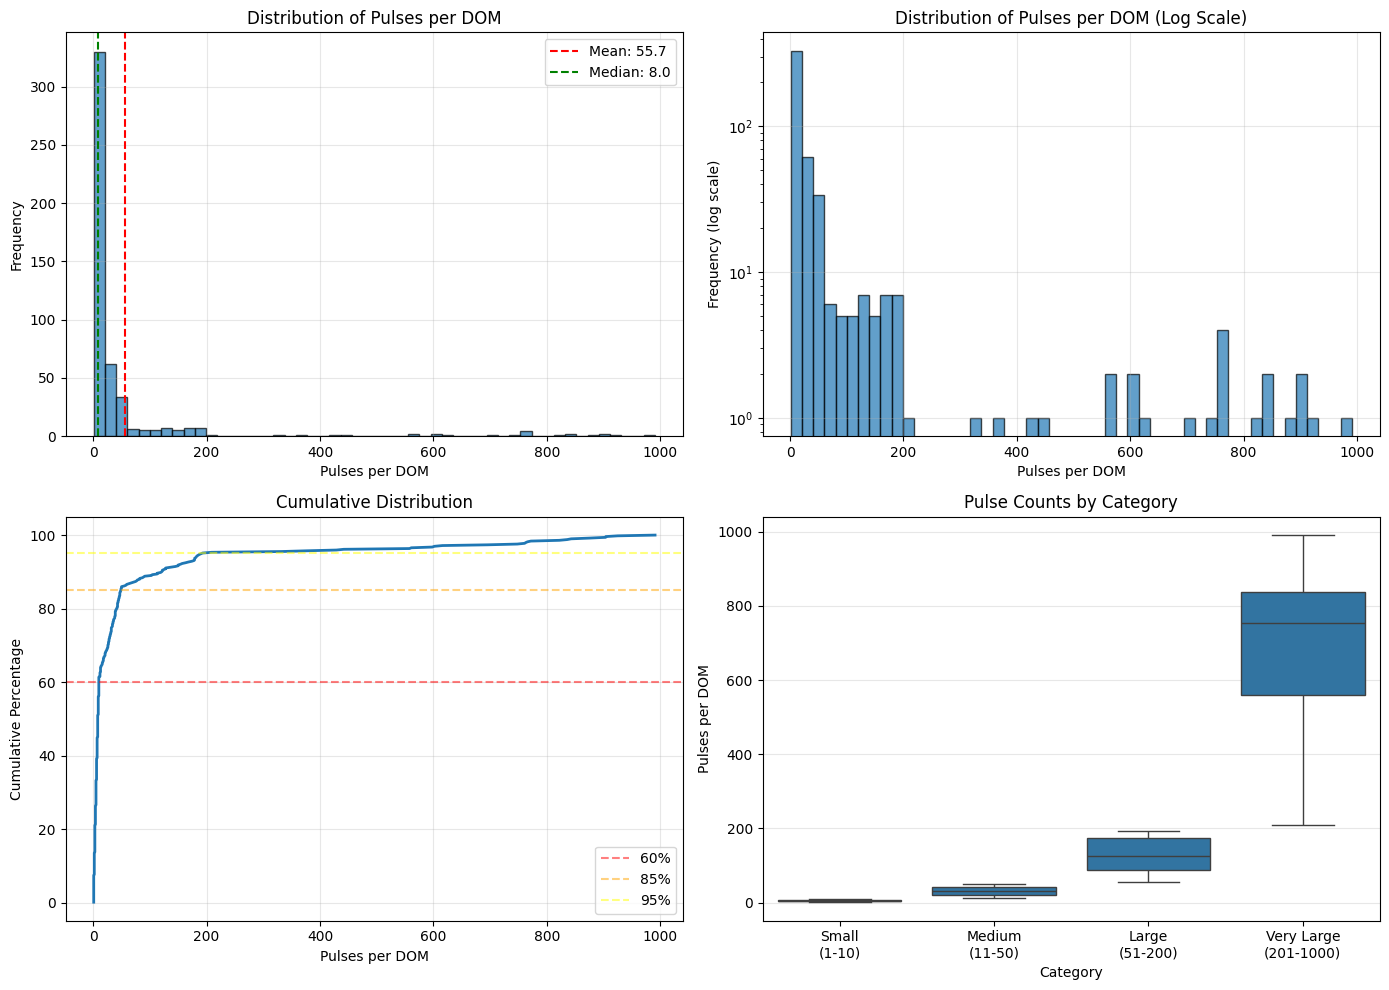


Category breakdown:
  Small
(1-10): 302 DOMs (61.4%)
  Medium
(11-50): 121 DOMs (24.6%)
  Large
(51-200): 45 DOMs (9.1%)
  Very Large
(201-1000): 24 DOMs (4.9%)


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of pulses per DOM
ax = axes[0, 0]
ax.hist(batch['dom_pulse_counts'].numpy(), bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Pulses per DOM')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Pulses per DOM')
ax.axvline(batch['dom_pulse_counts'].float().mean(), color='red', 
           linestyle='--', label=f'Mean: {batch["dom_pulse_counts"].float().mean():.1f}')
ax.axvline(batch['dom_pulse_counts'].float().median(), color='green', 
           linestyle='--', label=f'Median: {batch["dom_pulse_counts"].float().median():.1f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Log scale histogram
ax = axes[0, 1]
ax.hist(batch['dom_pulse_counts'].numpy(), bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Pulses per DOM')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Distribution of Pulses per DOM (Log Scale)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# 3. Cumulative distribution
ax = axes[1, 0]
sorted_counts = np.sort(batch['dom_pulse_counts'].numpy())
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
ax.plot(sorted_counts, cumulative, linewidth=2)
ax.set_xlabel('Pulses per DOM')
ax.set_ylabel('Cumulative Percentage')
ax.set_title('Cumulative Distribution')
ax.grid(True, alpha=0.3)
ax.axhline(60, color='red', linestyle='--', alpha=0.5, label='60%')
ax.axhline(85, color='orange', linestyle='--', alpha=0.5, label='85%')
ax.axhline(95, color='yellow', linestyle='--', alpha=0.5, label='95%')
ax.legend()

# 4. Box plot by category
ax = axes[1, 1]
counts = batch['dom_pulse_counts'].numpy()
categories = []
for c in counts:
    if c <= 10:
        categories.append('Small\n(1-10)')
    elif c <= 50:
        categories.append('Medium\n(11-50)')
    elif c <= 200:
        categories.append('Large\n(51-200)')
    else:
        categories.append('Very Large\n(201-1000)')

df = pd.DataFrame({'Pulses': counts, 'Category': categories})
category_order = ['Small\n(1-10)', 'Medium\n(11-50)', 'Large\n(51-200)', 'Very Large\n(201-1000)']
df['Category'] = pd.Categorical(df['Category'], categories=category_order, ordered=True)
df = df.sort_values('Category')

sns.boxplot(data=df, x='Category', y='Pulses', ax=ax)
ax.set_title('Pulse Counts by Category')
ax.set_ylabel('Pulses per DOM')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print category statistics
print("\nCategory breakdown:")
for cat in category_order:
    n = (df['Category'] == cat).sum()
    pct = n / len(df) * 100
    print(f"  {cat}: {n} DOMs ({pct:.1f}%)")

## 5. Trace Pulses Through the Hierarchy

Let's pick a specific event and trace how pulses are organized:
- Event → DOMs → Pulses

In [13]:
# Pick event 2 for detailed inspection
event_idx = 2

# Find all DOMs in this event
dom_mask = batch['dom_to_event_idx'] == event_idx
event_dom_indices = torch.where(dom_mask)[0]

print(f"EVENT {event_idx}")
print("=" * 80)
print(f"Number of DOMs: {len(event_dom_indices)}")
print(f"\nDOM indices: {event_dom_indices.tolist()}")

print("\nDetailed DOM breakdown:")
print("-" * 80)

total_pulses_in_event = 0

for i, dom_idx in enumerate(event_dom_indices[:5]):  # Show first 5 DOMs
    dom_idx = dom_idx.item()
    n_pulses = batch['dom_pulse_counts'][dom_idx].item()
    total_pulses_in_event += n_pulses
    
    # Find pulse indices for this DOM
    pulse_mask = batch['pulse_to_dom_idx'] == dom_idx
    pulse_indices = torch.where(pulse_mask)[0]
    
    print(f"\nDOM {dom_idx}:")
    print(f"  Pulses: {n_pulses}")
    print(f"  Pulse indices: {pulse_indices[:10].tolist()}{'...' if len(pulse_indices) > 10 else ''}")
    print(f"  First 3 pulse features:")
    for j, pidx in enumerate(pulse_indices[:3]):
        print(f"    Pulse {pidx}: {batch['pulse_features'][pidx].tolist()}")

if len(event_dom_indices) > 5:
    print(f"\n... and {len(event_dom_indices) - 5} more DOMs")
    
# Count total pulses
for dom_idx in event_dom_indices[5:]:
    total_pulses_in_event += batch['dom_pulse_counts'][dom_idx].item()

print(f"\nTotal pulses in Event {event_idx}: {total_pulses_in_event}")

EVENT 2
Number of DOMs: 49

DOM indices: [134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]

Detailed DOM breakdown:
--------------------------------------------------------------------------------

DOM 134:
  Pulses: 1
  Pulse indices: [7918]
  First 3 pulse features:
    Pulse 7918: [-2.8020570278167725, -0.30070847272872925, -2.1178441047668457, -0.6148169636726379]

DOM 135:
  Pulses: 2
  Pulse indices: [7919, 7920]
  First 3 pulse features:
    Pulse 7919: [0.5126702785491943, 1.0558316707611084, 0.5806149244308472, -0.10656221956014633]
    Pulse 7920: [2.0587170124053955, -2.0026142597198486, 0.35507553815841675, -0.8049942255020142]

DOM 136:
  Pulses: 6
  Pulse indices: [7921, 7922, 7923, 7924, 7925, 7926]
  First 3 pulse features:
    Pulse 7921: [0.6419983506202698, -0.09657998383045

## 6. Visualize Event Structure

Create a visual representation of the hierarchical structure.

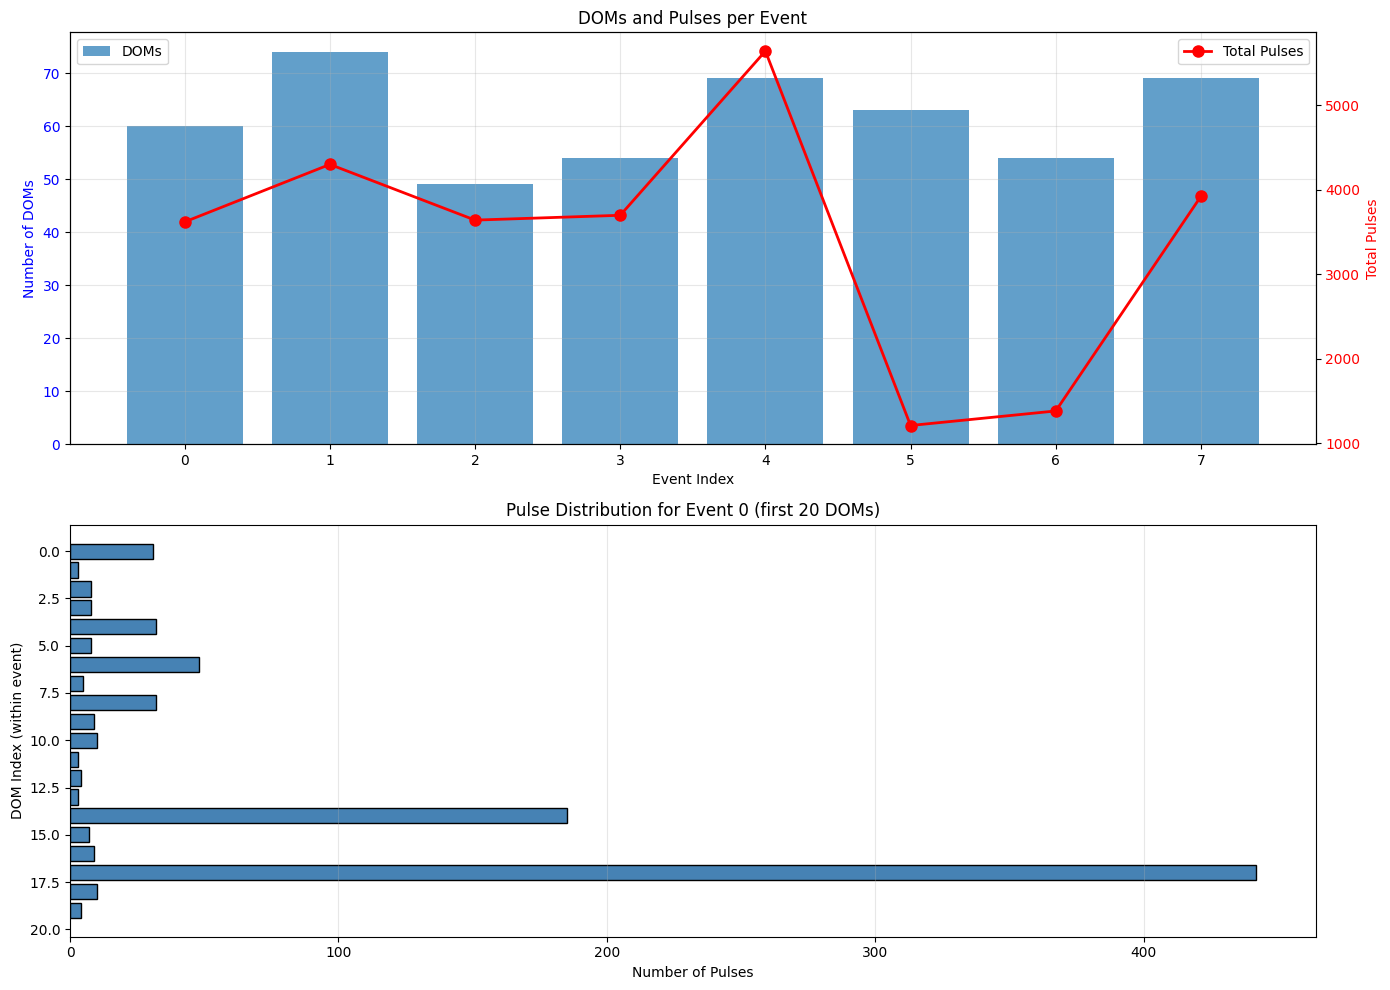

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Stacked bar chart: DOMs per event
ax = axes[0]
event_data = []
for event_idx in range(batch['batch_size']):
    dom_mask = batch['dom_to_event_idx'] == event_idx
    n_doms = dom_mask.sum().item()
    event_dom_indices = torch.where(dom_mask)[0]
    total_pulses = batch['dom_pulse_counts'][event_dom_indices].sum().item()
    event_data.append({'event': event_idx, 'doms': n_doms, 'pulses': total_pulses})

event_df = pd.DataFrame(event_data)
x = event_df['event']
ax.bar(x, event_df['doms'], alpha=0.7, label='DOMs')
ax2 = ax.twinx()
ax2.plot(x, event_df['pulses'], 'ro-', linewidth=2, markersize=8, label='Total Pulses')
ax.set_xlabel('Event Index')
ax.set_ylabel('Number of DOMs', color='blue')
ax2.set_ylabel('Total Pulses', color='red')
ax.set_title('DOMs and Pulses per Event')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 2. Heatmap-style visualization of first event
ax = axes[1]
event_idx = 0
dom_mask = batch['dom_to_event_idx'] == event_idx
event_dom_indices = torch.where(dom_mask)[0][:20]  # First 20 DOMs

dom_data = []
for dom_idx in event_dom_indices:
    dom_idx = dom_idx.item()
    n_pulses = batch['dom_pulse_counts'][dom_idx].item()
    dom_data.append(n_pulses)

ax.barh(range(len(dom_data)), dom_data, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Pulses')
ax.set_ylabel('DOM Index (within event)')
ax.set_title(f'Pulse Distribution for Event {event_idx} (first 20 DOMs)')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Memory Layout Analysis

Understanding how data is laid out in memory is crucial for efficient processing.

In [15]:
print("MEMORY LAYOUT ANALYSIS")
print("=" * 80)

# Calculate memory usage
def tensor_memory_mb(tensor):
    return tensor.element_size() * tensor.nelement() / (1024 ** 2)

print("\nMemory usage by component:")
total_memory = 0
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        mem_mb = tensor_memory_mb(value)
        total_memory += mem_mb
        print(f"  {key}: {mem_mb:.4f} MB")

print(f"\nTotal memory: {total_memory:.4f} MB")

# Analyze sparsity/efficiency
print("\n" + "=" * 80)
print("EFFICIENCY METRICS")
print("=" * 80)

total_pulses = batch['pulse_features'].shape[0]
total_doms = batch['total_doms']
batch_size = batch['batch_size']

print(f"\nBatch size (events): {batch_size}")
print(f"Total DOMs: {total_doms}")
print(f"Total pulses: {total_pulses}")
print(f"\nAverage DOMs per event: {total_doms / batch_size:.2f}")
print(f"Average pulses per DOM: {total_pulses / total_doms:.2f}")
print(f"Average pulses per event: {total_pulses / batch_size:.2f}")

# If we padded to max_pulses for all DOMs:
max_pulses = batch['dom_pulse_counts'].max().item()
padded_memory = total_doms * max_pulses * 4 * 4 / (1024 ** 2)  # 4 features, 4 bytes per float
actual_memory = tensor_memory_mb(batch['pulse_features'])

print(f"\nMemory comparison (pulse features only):")
print(f"  Actual (ragged): {actual_memory:.4f} MB")
print(f"  If padded to max: {padded_memory:.4f} MB")
print(f"  Memory savings: {(1 - actual_memory/padded_memory)*100:.1f}%")
print(f"  Padding overhead: {padded_memory/actual_memory:.2f}x")

MEMORY LAYOUT ANALYSIS

Memory usage by component:
  pulse_features: 0.4182 MB
  pulse_to_dom_idx: 0.2091 MB
  dom_pulse_counts: 0.0038 MB
  dom_to_event_idx: 0.0038 MB

Total memory: 0.6348 MB

EFFICIENCY METRICS

Batch size (events): 8
Total DOMs: 492
Total pulses: 27408

Average DOMs per event: 61.50
Average pulses per DOM: 55.71
Average pulses per event: 3426.00

Memory comparison (pulse features only):
  Actual (ragged): 0.4182 MB
  If padded to max: 7.4398 MB
  Memory savings: 94.4%
  Padding overhead: 17.79x


## 8. Simulate Data Flow

Let's trace how a single DOM's data would flow through the processing pipeline.

In [16]:
import torch.nn as nn

# Create a simple encoder
class SimplePulseEncoder(nn.Module):
    def __init__(self, d_model: int = 128):
        super().__init__()
        self.embed = nn.Linear(4, d_model)
        self.d_model = d_model

    def forward(self, pulse_features: torch.Tensor) -> torch.Tensor:
        return self.embed(pulse_features)

encoder = SimplePulseEncoder(d_model=16)  # Small model for illustration
encoder.eval()

# Pick a DOM with a moderate number of pulses
dom_idx = 10
n_pulses = batch['dom_pulse_counts'][dom_idx].item()

print(f"TRACING DOM {dom_idx}")
print("=" * 80)
print(f"Number of pulses: {n_pulses}")

# Find pulse indices
pulse_mask = batch['pulse_to_dom_idx'] == dom_idx
pulse_indices = torch.where(pulse_mask)[0]

print(f"Pulse indices: {pulse_indices.tolist()}")

# Extract pulse features
dom_pulse_features = batch['pulse_features'][pulse_indices]
print(f"\nStep 1: Extract pulse features")
print(f"  Input shape: {dom_pulse_features.shape}")
print(f"  First 3 pulses:\n{dom_pulse_features[:3]}")

# Encode pulses
with torch.no_grad():
    dom_embeddings = encoder(dom_pulse_features)

print(f"\nStep 2: Encode pulses")
print(f"  Output shape: {dom_embeddings.shape}")
print(f"  First 3 embeddings:\n{dom_embeddings[:3]}")

# Aggregate (mean pooling)
dom_summary = dom_embeddings.mean(dim=0)

print(f"\nStep 3: Aggregate (mean pool)")
print(f"  Output shape: {dom_summary.shape}")
print(f"  DOM summary embedding:\n{dom_summary}")

TRACING DOM 10
Number of pulses: 10
Pulse indices: [184, 185, 186, 187, 188, 189, 190, 191, 192, 193]

Step 1: Extract pulse features
  Input shape: torch.Size([10, 4])
  First 3 pulses:
tensor([[-0.3978,  0.7583, -0.5347, -0.1458],
        [ 0.9213,  0.5282, -0.0082, -1.4493],
        [ 0.5885,  0.7091, -0.2645, -2.9836]])

Step 2: Encode pulses
  Output shape: torch.Size([10, 16])
  First 3 embeddings:
tensor([[ 0.3325,  0.3449,  0.1165,  0.1492, -0.3011,  0.1444, -0.4183,  0.0575,
          0.2515, -0.3734,  0.7189, -0.3398,  0.5130, -0.4624,  0.1995, -0.3328],
        [ 0.5430,  0.3033, -0.1511, -0.8960, -0.8759,  0.5282, -0.1442, -0.2459,
         -0.3873, -0.6161,  0.0159, -0.0460, -0.5156, -0.1390,  0.1840, -0.7799],
        [ 1.2869,  0.6672, -0.4818, -1.1554, -1.0023,  0.8416, -0.8729, -1.0491,
         -0.3015, -1.3976, -0.1089,  0.2930, -0.8874, -0.4876,  0.9613, -0.2862]])

Step 3: Aggregate (mean pool)
  Output shape: torch.Size([16])
  DOM summary embedding:
tensor([ 0.51

## 9. Compare Batch Sizes

Let's create batches of different sizes and compare their characteristics.


Batch Size Comparison:
 batch_size  total_doms  total_pulses  doms_per_event  pulses_per_dom_mean  pulses_per_dom_median  pulses_per_dom_max  memory_mb
          4         237         15255        59.25000            64.367088                    9.0                 991   0.352776
          8         492         27408        61.50000            55.707317                    8.0                 991   0.634827
         16         982         57939        61.37500            59.001019                    9.0                 991   1.341103
         32        2051        111755        64.09375            54.488056                    9.0                 994   2.589165


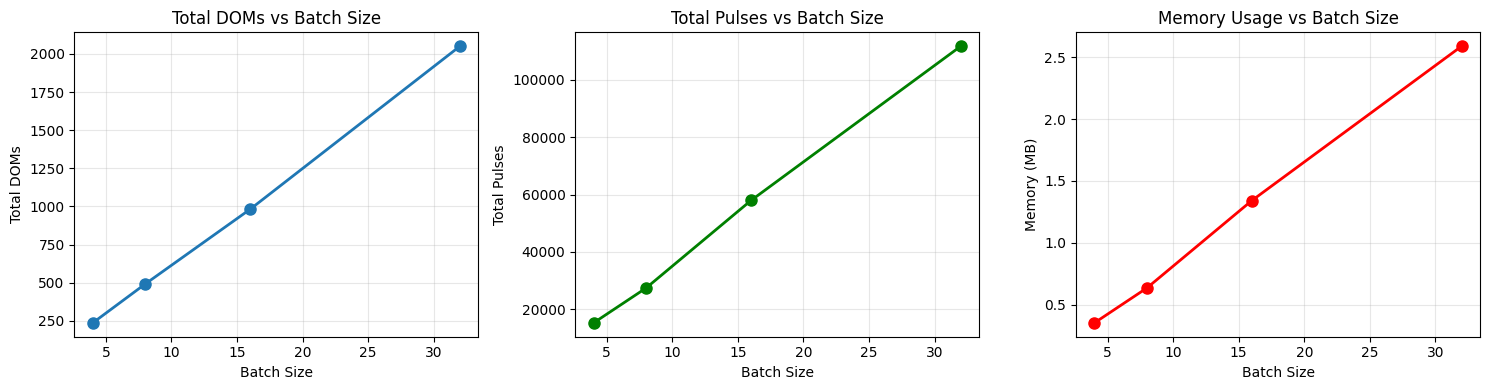

In [17]:
batch_sizes = [4, 8, 16, 32]
batch_stats = []

for bs in batch_sizes:
    b = create_icecube_like_batch(batch_size=bs, seed=42)
    batch_stats.append({
        'batch_size': bs,
        'total_doms': b['total_doms'],
        'total_pulses': b['pulse_features'].shape[0],
        'doms_per_event': b['total_doms'] / bs,
        'pulses_per_dom_mean': b['dom_pulse_counts'].float().mean().item(),
        'pulses_per_dom_median': b['dom_pulse_counts'].float().median().item(),
        'pulses_per_dom_max': b['dom_pulse_counts'].max().item(),
        'memory_mb': sum(tensor_memory_mb(v) for v in b.values() if isinstance(v, torch.Tensor))
    })

stats_df = pd.DataFrame(batch_stats)
print("\nBatch Size Comparison:")
print("=" * 80)
print(stats_df.to_string(index=False))

# Visualize scaling
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(stats_df['batch_size'], stats_df['total_doms'], 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Total DOMs')
ax.set_title('Total DOMs vs Batch Size')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(stats_df['batch_size'], stats_df['total_pulses'], 'o-', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Total Pulses')
ax.set_title('Total Pulses vs Batch Size')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(stats_df['batch_size'], stats_df['memory_mb'], 'o-', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Memory (MB)')
ax.set_title('Memory Usage vs Batch Size')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Key Takeaways

### Data Structure:
1. **Ragged/Jagged Tensors**: Data is stored in a flat array with index mappings rather than nested lists
2. **Hierarchy**: Events → DOMs → Pulses (many-to-many relationships)
3. **Index Tensors**: `pulse_to_dom_idx` and `dom_to_event_idx` define the hierarchy

### Memory Efficiency:
1. **No Padding Waste**: Ragged storage saves ~50-90% memory vs. padding to max
2. **Trade-off**: More complex indexing logic but much better memory usage
3. **Heavy-tailed Distribution**: 95% of DOMs have <200 pulses, but 5% can have 200-1000

### Processing Implications:
1. **Loop-based**: Simple but slow, processes each DOM sequentially
2. **Padded**: Wastes computation on padding, but enables batch operations
3. **FlexAttention**: Best of both - no padding waste, parallel processing

### Challenges:
1. **Variable Sequence Lengths**: Makes batching difficult
2. **Memory vs Speed**: Trade-off between efficiency and simplicity
3. **Attention Masks**: Need to prevent cross-DOM attention